In [1]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors

In [2]:
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer

In [3]:
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

In [4]:
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats

In [5]:
def train(model, criterion, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    
    batch_pos = opts['batch_pos']
    batch_neg = opts['batch_neg']
    batch_test = opts['batch_test']
    batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)

    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg_cand*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):

        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg_cand
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        # hard negative mining
        if batch_neg_cand > batch_neg:
            model.eval()
            for start in range(0,batch_neg_cand,batch_test):
                end = min(start+batch_test,batch_neg_cand)
                score = model(batch_neg_feats[start:end], in_layer=in_layer)
                if start==0:
                    neg_cand_score = score.data[:,1].clone()
                else:
                    neg_cand_score = torch.cat((neg_cand_score, score.data[:,1].clone()),0)

            _, top_idx = neg_cand_score.topk(batch_neg)
            batch_neg_feats = batch_neg_feats.index_select(0, Variable(top_idx))
            model.train()
        
        # forward
        pos_score = model(batch_pos_feats, in_layer=in_layer)
        neg_score = model(batch_neg_feats, in_layer=in_layer)
        
        # optimize
        loss = criterion(pos_score, neg_score)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()

        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

        
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].data.clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].data.clone()),0)
    return pos_data

In [6]:
np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'DragonBaby'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()
model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers

/usr/local/lib/python2.7/dist-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU2 GeForce GT 740 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [7]:
criterion = BinaryLoss()
init_optimizer = set_optimizer(model, opts['lr_init'])
update_optimizer = set_optimizer(model, opts['lr_update'])
image = Image.open(img_list[0]).convert('RGB')

In [8]:
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg

In [9]:
target_bbox

array([160.,  83.,  56.,  65.])

In [10]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 1.5, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])

#neg_examples = gen_samples(SampleGenerator('hole', image.size, 0.3,2.0),target_bbox, 1000, [0,0.5])
neg_examples = gen_samples(SampleGenerator('part', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])

In [11]:
neg_examples.shape

(786, 4)

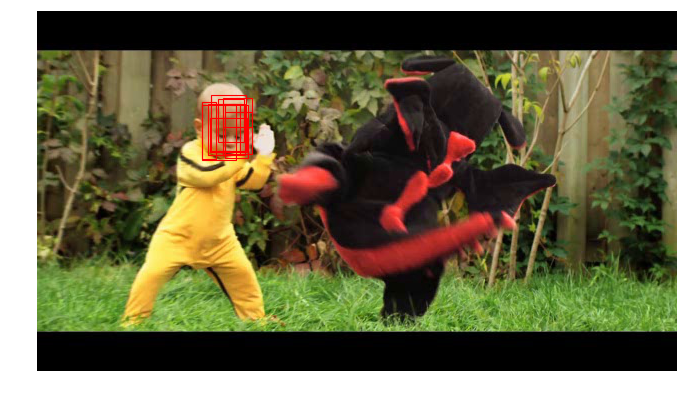

In [12]:
show_bbox(image,neg_examples[:10,:])

In [13]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats

In [14]:
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])

/home/prisimage/tracker/py-MDNetST/modules/model.py:156: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pos_loss = -F.log_softmax(pos_score)[:,1]
/home/prisimage/tracker/py-MDNetST/modules/model.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  neg_loss = -F.log_softmax(neg_score-5)[:,0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


In [15]:
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')

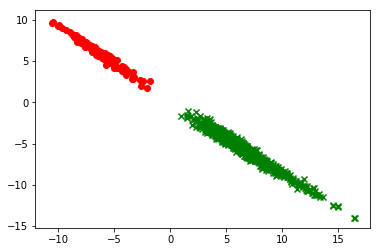

In [16]:
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')
plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')


In [18]:
p_pos = F.softmax(pos_out)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [19]:
p_pos

tensor([[ 2.5271e-05,  9.9997e-01],
        [ 2.0224e-06,  1.0000e+00],
        [ 2.8267e-07,  1.0000e+00],
        [ 2.6370e-05,  9.9997e-01],
        [ 1.3386e-05,  9.9999e-01],
        [ 9.6295e-03,  9.9037e-01],
        [ 1.0268e-04,  9.9990e-01],
        [ 5.6435e-06,  9.9999e-01],
        [ 1.6933e-09,  1.0000e+00],
        [ 1.3905e-06,  1.0000e+00],
        [ 1.9591e-06,  1.0000e+00],
        [ 2.1859e-06,  1.0000e+00],
        [ 1.7186e-07,  1.0000e+00],
        [ 4.5874e-03,  9.9541e-01],
        [ 1.3159e-02,  9.8684e-01],
        [ 5.7828e-06,  9.9999e-01],
        [ 1.0188e-06,  1.0000e+00],
        [ 4.4848e-09,  1.0000e+00],
        [ 1.3322e-06,  1.0000e+00],
        [ 4.1212e-05,  9.9996e-01],
        [ 1.7296e-04,  9.9983e-01],
        [ 4.5614e-07,  1.0000e+00],
        [ 7.2903e-06,  9.9999e-01],
        [ 3.2845e-06,  1.0000e+00],
        [ 3.5408e-06,  1.0000e+00],
        [ 1.5403e-07,  1.0000e+00],
        [ 2.7170e-05,  9.9997e-01],
        [ 2.2410e-04,  9.997

In [20]:
p_pos_sigmoid = F.sigmoid(pos_out)
p_pos_sigmoid

tensor([[ 0.0053,  0.9953],
        [ 0.0011,  0.9981],
        [ 0.0004,  0.9993],
        [ 0.0041,  0.9937],
        [ 0.0031,  0.9957],
        [ 0.0677,  0.8820],
        [ 0.0068,  0.9852],
        [ 0.0020,  0.9971],
        [ 0.0000,  0.9999],
        [ 0.0012,  0.9988],
        [ 0.0009,  0.9979],
        [ 0.0014,  0.9984],
        [ 0.0003,  0.9994],
        [ 0.0648,  0.9376],
        [ 0.1466,  0.9280],
        [ 0.0019,  0.9970],
        [ 0.0009,  0.9989],
        [ 0.0000,  0.9999],
        [ 0.0011,  0.9988],
        [ 0.0046,  0.9912],
        [ 0.0132,  0.9873],
        [ 0.0006,  0.9992],
        [ 0.0028,  0.9974],
        [ 0.0013,  0.9975],
        [ 0.0017,  0.9979],
        [ 0.0003,  0.9996],
        [ 0.0046,  0.9941],
        [ 0.0146,  0.9851],
        [ 0.0006,  0.9989],
        [ 0.0013,  0.9977],
        [ 0.0018,  0.9962],
        [ 0.0013,  0.9969],
        [ 0.0073,  0.9891],
        [ 0.0008,  0.9990],
        [ 0.0359,  0.9574],
        [ 0.0015,  0

In [21]:
p_neg_sigmoid = F.sigmoid(neg_out)
p_neg_sigmoid

tensor([[ 9.8984e-01,  3.4992e-02],
        [ 9.9592e-01,  6.6276e-03],
        [ 9.8076e-01,  3.0686e-02],
        ...,
        [ 9.7000e-01,  1.0800e-01],
        [ 9.9862e-01,  4.0364e-03],
        [ 9.9849e-01,  3.6176e-03]], device='cuda:0')

In [18]:
pos_out_5 = forward_samples(model, image, pos_examples,out_layer='fc5')
neg_out_5 = forward_samples(model, image, neg_examples,out_layer='fc5')
pos_out_5 = pos_out_5.cpu().numpy()
neg_out_5 = neg_out_5.cpu().numpy()

In [23]:

out_5 = np.concatenate((neg_out_5,pos_out_5))
out_5.shape

(5120, 512)

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit(out_5)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

In [ ]:
## this shows that negative consist of serveral classes maybe 3 or 4

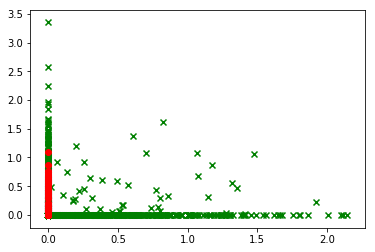

In [26]:
for i in range(5120):
    if i<5000:
        plt.scatter(out_5[i,0],out_5[i,1],c='g',marker='x')
    else:
        plt.scatter(out_5[i,0],out_5[i,1],c='r',marker='o')

In [27]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 1.5, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])

neg_examples = gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),target_bbox, 1000, [0,0.2])

In [36]:
pos_out_5 = forward_samples(model, image, pos_examples,out_layer='fc5')
neg_out_5 = forward_samples(model, image, neg_examples,out_layer='fc5')
pos_out_5 = pos_out_5.cpu().numpy()
neg_out_5 = neg_out_5.cpu().numpy()

In [37]:
out_5 = np.concatenate((neg_out_5,pos_out_5))
out_5.shape

(1111, 512)

In [38]:
tsne = TSNE()
tsne.fit(out_5)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

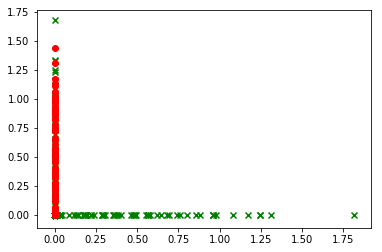

In [39]:
for i in range(1111):
    if i<1000:
        plt.scatter(out_5[i,0],out_5[i,1],c='g',marker='x')
    else:
        plt.scatter(out_5[i,0],out_5[i,1],c='r',marker='o')

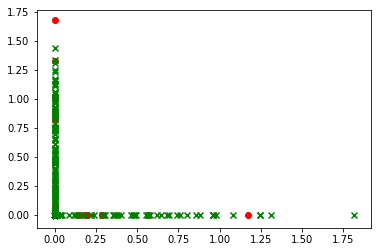

In [40]:
out_5 = np.concatenate((neg_out_5,pos_out_5))
out_5.shape
tsne = TSNE()
tsne.fit(out_5)
for i in range(1111):
    if i<111:
        plt.scatter(out_5[i,0],out_5[i,1],c='r',marker='o')
    else:
        plt.scatter(out_5[i,0],out_5[i,1],c='g',marker='x')

In [18]:
np.random.rand(100)

array([0.66933199, 0.83993408, 0.32897969, 0.38673292, 0.33385213,
       0.22583378, 0.38342962, 0.64825469, 0.25886961, 0.00557493,
       0.09186647, 0.82885645, 0.9860844 , 0.63683345, 0.79451338,
       0.35261849, 0.90264904, 0.67272505, 0.47772088, 0.31304224,
       0.94422145, 0.01294681, 0.93498784, 0.88126908, 0.73654663,
       0.53854429, 0.80606393, 0.81004802, 0.76525052, 0.13867718,
       0.72304128, 0.24074541, 0.04408241, 0.10696812, 0.89614773,
       0.13579689, 0.8216896 , 0.49948678, 0.49675031, 0.87508108,
       0.32901297, 0.51531274, 0.89424502, 0.15550014, 0.48722199,
       0.77046849, 0.04661212, 0.54393982, 0.48636623, 0.49577054,
       0.77326026, 0.00251352, 0.77767293, 0.4269969 , 0.96639035,
       0.01613572, 0.71722048, 0.81498263, 0.92400146, 0.30699257,
       0.78773345, 0.05057728, 0.70320089, 0.92426405, 0.91506772,
       0.93853909, 0.22110805, 0.95673967, 0.89220106, 0.56405717,
       0.79175308, 0.66361314, 0.6022078 , 0.57071145, 0.81608